# Advanced usage

This notebook replicates what was done in the *simple_usage* notebooks, but this time with the advanced API. The advanced API is required if we want to use non-standard affinity methods that better preserve global structure.

If you are comfortable with the advanced API, please refer to the *preserving_global_structure* notebook for a guide how obtain better embeddings and preserve more global structure.

In [1]:
from openTSNE import TSNEEmbedding
from openTSNE.affinity import PerplexityBasedNN
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

### Load data

In [2]:
import gzip
import pickle

with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


### Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [5]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

30021 training samples
14787 test samples


### Create a t-SNE embedding

Like in the *simple_usage* notebook, we will run the standard t-SNE optimization, as implemented in most software packages. We would note, again, that these are **NOT** the recommended parameters, since much can be done to improve the embedding.

Please refer to the *preserving_global_structure* notebook for a guide how obtain better embeddings.

#### 1. Compute the affinities between data points

In [6]:
%%time
affinities_train = PerplexityBasedNN(
    x_train,
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

CPU times: user 28.7 s, sys: 664 ms, total: 29.4 s
Wall time: 12.4 s


#### 2. Generate initial coordinates for our embedding

In [7]:
%time init_train = initialization.random(x_train, random_state=42)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 3.06 ms


#### 3. Construct the `TSNEEmbedding` object

In [8]:
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

#### 4. Optimize embedding

1. Early exaggeration phase

In [9]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  6.4513, 50 iterations in 0.8767 sec
Iteration  100, KL divergence  5.3525, 50 iterations in 0.8300 sec
Iteration  150, KL divergence  5.2045, 50 iterations in 0.7767 sec
Iteration  200, KL divergence  5.1507, 50 iterations in 0.8585 sec
Iteration  250, KL divergence  5.1257, 50 iterations in 0.8109 sec
CPU times: user 32.5 s, sys: 960 ms, total: 33.4 s
Wall time: 4.2 s


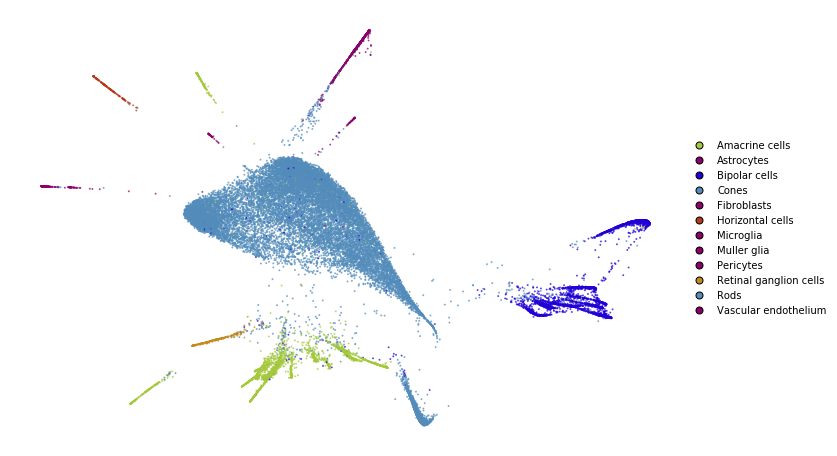

In [10]:
utils.plot(embedding_train_1, y_train, colors=utils.MACOSKO_COLORS)

2. Regular optimization

In [11]:
%time embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)

Iteration   50, KL divergence  3.8001, 50 iterations in 0.9478 sec
Iteration  100, KL divergence  3.4082, 50 iterations in 0.9263 sec
Iteration  150, KL divergence  3.1950, 50 iterations in 1.1735 sec
Iteration  200, KL divergence  3.0542, 50 iterations in 1.3052 sec
Iteration  250, KL divergence  2.9519, 50 iterations in 1.6980 sec
Iteration  300, KL divergence  2.8734, 50 iterations in 2.1278 sec
Iteration  350, KL divergence  2.8120, 50 iterations in 2.3823 sec
Iteration  400, KL divergence  2.7626, 50 iterations in 2.8116 sec
Iteration  450, KL divergence  2.7229, 50 iterations in 3.4133 sec
Iteration  500, KL divergence  2.6905, 50 iterations in 3.7323 sec
Iteration  550, KL divergence  2.6640, 50 iterations in 5.0755 sec
Iteration  600, KL divergence  2.6421, 50 iterations in 4.6033 sec
Iteration  650, KL divergence  2.6241, 50 iterations in 4.9241 sec
Iteration  700, KL divergence  2.6090, 50 iterations in 6.4102 sec
Iteration  750, KL divergence  2.5963, 50 iterations in 5.3969

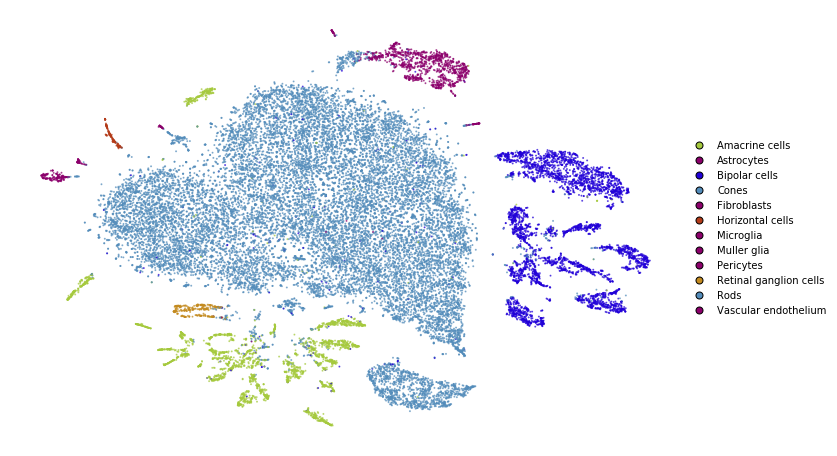

In [12]:
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS)

### Transform

In [13]:
%%time
embedding_test = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)

CPU times: user 2.58 s, sys: 20 ms, total: 2.6 s
Wall time: 741 ms


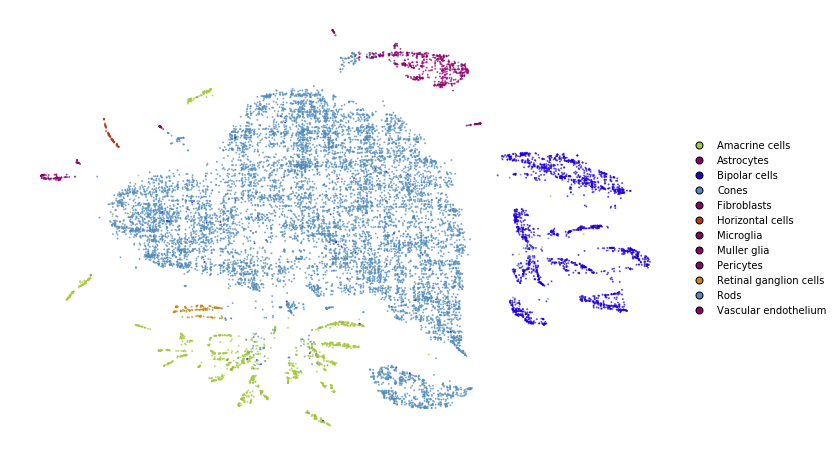

In [14]:
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS)

In [15]:
%%time
embedding_test_1 = embedding_test.optimize(
    n_iter=100,
    learning_rate=1,
    exaggeration=2,
    momentum=0,
)

Iteration   50, KL divergence  212582.8730, 50 iterations in 7.0618 sec
Iteration  100, KL divergence  212505.8839, 50 iterations in 4.1497 sec
CPU times: user 1min 24s, sys: 4.8 s, total: 1min 29s
Wall time: 11.3 s


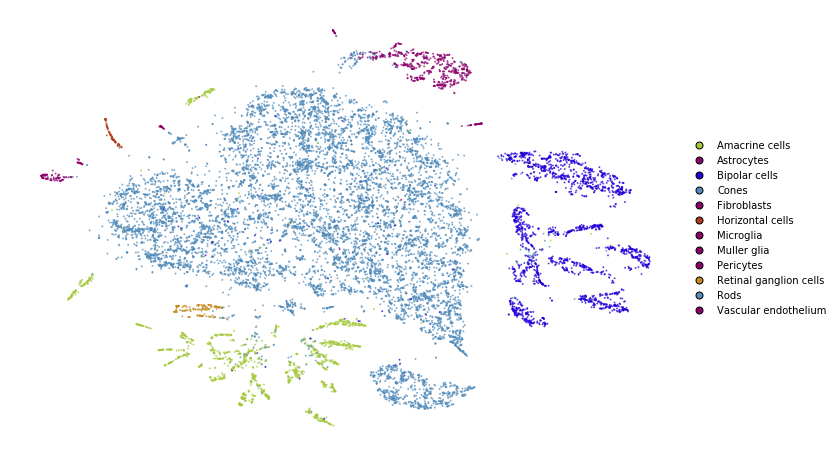

In [16]:
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS)

### Together

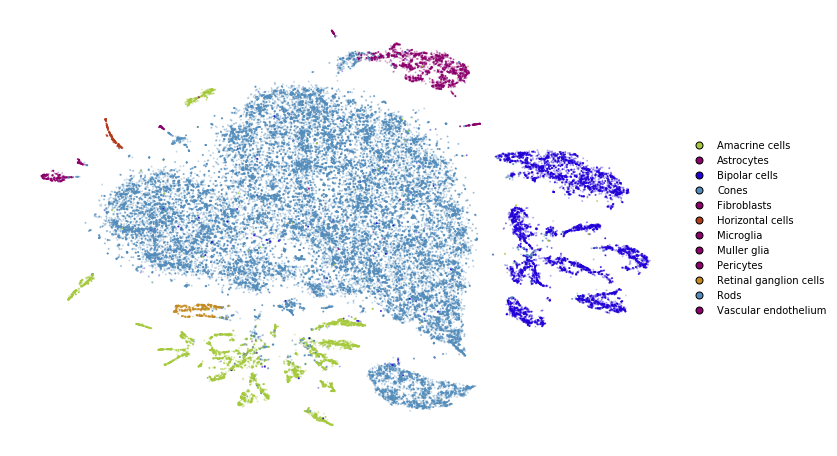

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS, alpha=0.25, ax=ax)
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS, alpha=0.75, ax=ax)